# Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import torch
import matplotlib.pyplot as plt

In [3]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [4]:
DEVICE = torch.device('cuda')

In [5]:
%run ../utils/__init__.py
%run ../datasets/__init__.py
%run ../models/checkpoint/__init__.py
%run ../utils/nlp.py

In [6]:
config_logging(logging.INFO)

# Load data

In [7]:
kwargs = {
    'dataset_name': 'iu-x-ray',
    'dataset_type': 'all',
    'batch_size': 25,
    'image_format': 'L',
    'frontal_only': True,
    'norm_by_sample': True,
    'image_size': (1024, 1024),
}

dataloader = prepare_data_classification(**kwargs)
len(dataloader.dataset)

[__main__] INFO(02-09 20:37) Loading iu-x-ray/all cl-dataset, bs=25 imgsize=(1024, 1024) version=None format=L
[__main__] INFO(02-09 20:37) 	Dataset size: 3800


3800

# Load model

In [8]:
run_name = '1202_015907_jsrt_scan_lr0.0005_normS_size1024_wce1-6-3-3_aug10_sch-iou-p5-f0.5'
debug = False

In [9]:
compiled_model = load_compiled_model_segmentation(run_name, debug=debug, device=DEVICE)
compiled_model.metadata

{'model_kwargs': {'model_name': 'scan', 'n_classes': 4},
 'opt_kwargs': {'lr': 0.0005},
 'lr_sch_kwargs': {'mode': 'max',
  'threshold_mode': 'abs',
  'factor': 0.5,
  'patience': 5,
  'verbose': True},
 'hparams': {'loss_weights': [0.1, 0.6, 0.3, 0.3],
  'early_stopping': True,
  'early_stopping_kwargs': {'patience': 20, 'metric': 'iou', 'min_delta': 0},
  'lr_sch_metric': 'iou'},
 'dataset_kwargs': {'dataset_name': 'jsrt',
  'batch_size': 20,
  'image_size': [1024, 1024],
  'num_workers': 2,
  'norm_by_sample': True},
 'dataset_train_kwargs': {'shuffle': None,
  'augment': True,
  'augment_label': None,
  'augment_class': None,
  'augment_times': 10,
  'augment_kwargs': {'crop': 0.8,
   'translate': 0.1,
   'rotation': 15,
   'contrast': 0.8,
   'brightness': 0.8,
   'shear': [10, 10]}},
 'run_name': '1202_015907_jsrt_scan_lr0.0005_normS_size1024_wce1-6-3-3_aug10_sch-iou-p5-f0.5'}

# Segment images

And save masks

## Functions

In [10]:
from PIL import Image
from tqdm.notebook import tqdm

In [11]:
%run ../utils/shapes.py

In [12]:
def calculate_output(batch):
    images = batch.image.to(DEVICE)

    with torch.no_grad():
        outputs = compiled_model.model(images).detach().cpu()
        # shape: batch_size, n_labels, height, width

    _, outputs = outputs.max(dim=1)
    # shape: batch_size, height, width

    return outputs

In [13]:
def assertions(mask, image_fname):
    min_value = mask.min()
    if min_value != 0:
        print(f'[{image_fname}] Minimum must be zero, got {min_value}')
    
    max_value = mask.max()
    if max_value != 3:
        print(f'[{image_fname}] Maximum must be three, got {min_value}')

In [14]:
def get_filepath(masks_folder, image_name):
    filepath = os.path.join(masks_folder, image_name)
    if not filepath.endswith('.png'):
        filepath += '.png'
    return filepath

## Run segmentation

In [15]:
VERSION = 'v1'
EXIST_OK = False

In [16]:
masks_folder = os.path.join(dataloader.dataset.dataset_dir, 'masks', VERSION)
os.makedirs(masks_folder, exist_ok=EXIST_OK)

In [17]:
already_calculated = set(os.listdir(masks_folder))
len(already_calculated)

0

In [20]:
# HACK: remove images that are already calculated
# Use this when calculation stopped half-way

# df = dataloader.dataset.label_index
# df = df.loc[~df['FileName'].isin(already_calculated)]
# df.reset_index(drop=True, inplace=True)
# dataloader.dataset.label_index = df
# len(dataloader.dataset), len(dataloader)

(84565, 3383)

In [18]:
state = tqdm(total=len(dataloader.dataset))
errors = []

for batch in dataloader:
    if all(image_name in already_calculated for image_name in batch.image_fname):
        state.update(len(batch.image_fname))
        continue
    
    outputs = calculate_output(batch).cpu()
    
    for image_name, mask in zip(batch.image_fname, outputs):
        if image_name in already_calculated:
            state.update(1)
            continue
            # raise Exception('Overriding previous mask!')

        mask = mask.to(torch.uint8).numpy()
        # shape: height, width
        
        assertions(mask, image_name)
        
        # Keep only largest shape:
        polygons = calculate_polygons(mask)
        largest_polygons = get_largest_shapes(polygons, name=image_name)
        mask = polygons_to_array(largest_polygons, mask.shape)

        assertions(mask, image_name)
        
        if any(len(coords) == 0 for coords, organ_idx in largest_polygons):
            errors.append(image_name)

        # Save to file
        mask = Image.fromarray(mask, mode='L')
        out_fpath = get_filepath(masks_folder, image_name)
        mask.save(out_fpath)

        state.update(1)

  0%|          | 0/3800 [00:00<?, ?it/s]

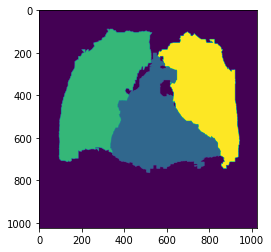

In [20]:
plt.imshow(mask)

## Search empty image

In [24]:
image_names = list(dataloader.dataset.label_index['FileName'])
len(image_names)

84565

In [64]:
kwargs = {
    'dataset_name': 'cxr14',
    'dataset_type': 'all',
    'batch_size': 25,
    'image_format': 'L',
    'frontal_only': True,
    'norm_by_sample': True,
    'image_size': (1024, 1024),
    'masks': True,
    'masks_version': 'v1',
    'images_version': 'clahe',
}

dataloader = prepare_data_classification(**kwargs)
new_dataset = dataloader.dataset
len(new_dataset)

[__main__] INFO(02-09 20:35) Loading cxr14/all cl-dataset, bs=25 imgsize=(1024, 1024) version=clahe format=L
[__main__] INFO(02-09 20:35) 	Dataset size: 112119


112119

In [46]:
errors = []

for image_name in tqdm(image_names):
    mask = new_dataset.load_mask(image_name) # shape: n_organs, height, width
    mask = squeeze_masks(mask) # shape: height, width
    
    polygons = calculate_polygons(mask)
    largest_polygons = get_largest_shapes(polygons, name=image_name)
    
    if any(len(coords) == 0 for coords, organ_idx in largest_polygons):
        errors.append(image_name)
        
len(errors)

  0%|          | 0/84565 [00:00<?, ?it/s]

[__main__] WARNING(02-09 19:53) Empty polygon for organ=1, name=00012249_001.png
[__main__] WARNING(02-09 19:55) Empty polygon for organ=1, name=00013597_000.png
[__main__] WARNING(02-09 19:56) Empty polygon for organ=1, name=00013774_015.png
[__main__] WARNING(02-09 20:08) Empty polygon for organ=1, name=00020006_001.png
[__main__] WARNING(02-09 20:10) Empty polygon for organ=2, name=00021201_042.png
[__main__] WARNING(02-09 20:21) Empty polygon for organ=2, name=00029041_016.png
[__main__] WARNING(02-09 20:21) Empty polygon for organ=2, name=00029041_017.png


7

In [47]:
errors

['00012249_001.png',
 '00013597_000.png',
 '00013774_015.png',
 '00020006_001.png',
 '00021201_042.png',
 '00029041_016.png',
 '00029041_017.png']

## Load one sample by name

To debug

In [48]:
image_names = list(errors)
len(image_names)

7

In [62]:
df = dataloader.dataset.label_index
rows = df.loc[df['FileName'].isin(image_names)]
indexes = list(rows.index)
indexes

[48322, 53874, 54987, 81422, 85931, 107529, 107530]

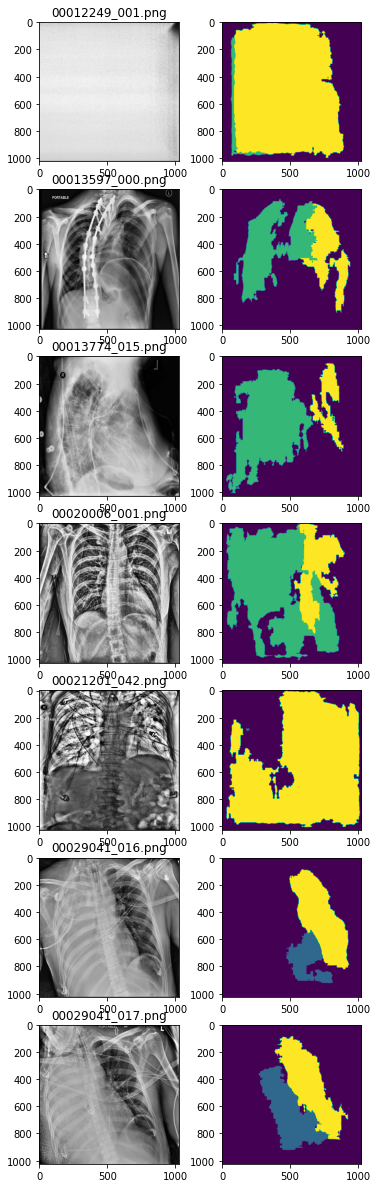

In [65]:
n_rows = len(indexes)
n_cols = 2

plt.figure(figsize=(n_cols*3, n_rows*3))

for counter, index in enumerate(indexes):
    item = new_dataset[index]
    
    mask = squeeze_masks(item.masks)
    
    row_index = counter * n_cols
    
    plt.subplot(n_rows, n_cols, row_index + 1)
    plt.title(item.image_fname)
    plt.imshow(tensor_to_range01(item.image[0]), cmap='gray')
    
    plt.subplot(n_rows, n_cols, row_index + 2)
    plt.imshow(mask)

#     plt.subplot(1, 2, 2)
#     plt.gca().invert_yaxis()
#     for coords, value in largest_polygons2:
#         if len(coords) == 0:
#             continue
#         x_values, y_values = zip(*coords)
#         plt.plot(x_values, y_values)

# Debug load dataset

In [46]:
%run ../utils/common.py

In [ ]:
%run ../datasets/iu_xray.py

dataset = IUXRayDataset('all', image_size=(1024, 1024), frontal_only=True, masks=True)
len(dataset)

In [47]:
%run ../datasets/cxr14.py

dataset = CXR14Dataset('all', image_size=(1024, 1024), frontal_only=True,
                       masks=True, masks_version='v1')
len(dataset)

112120

In [40]:
def squeeze_masks(masks):
    n_dim = len(masks.size())
    if n_dim == 2:
        return masks
    
    n_organs = masks.size(0)
    multiplier = torch.arange(0, n_organs).unsqueeze(-1).unsqueeze(-1)
    return (multiplier * masks).sum(dim=0)

In [52]:
item = dataset[1]
item.image.size(), item.masks.size(), item.image_fname

(torch.Size([3, 1024, 1024]), torch.Size([4, 1024, 1024]), '00000001_001.png')

(-0.5, 1023.5, 1023.5, -0.5)

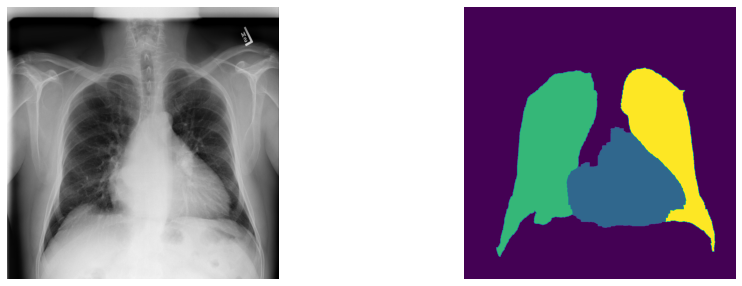

In [53]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(tensor_to_range01(item.image).permute(1, 2, 0))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(squeeze_masks(item.masks))
plt.axis('off')